In [53]:
# Makes File Handling Easier
import os

# PyTorch model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# Image datasets and image manipulation
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.io import read_image
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd

# Image display
import matplotlib.pyplot as plt
import numpy as np

# PyTorch TensorBoard support
from torch.utils.tensorboard.writer import SummaryWriter

# ? Not sure what these are for
import scipy.io as scio
import shutil

In [54]:
# Create train, valid and test directories to sort dataset into.
def makePartitionDirs():
    for i in range(1, 103):
        os.makedirs("data/102flowers/train/" + str(i), exist_ok=True)
        os.makedirs("data/102flowers/test/" + str(i), exist_ok=True)
        os.makedirs("data/102flowers/valid/" + str(i), exist_ok=True)


# Distribute dataset into train, valid and test directories according to setid.mat specifications.
def partitionData(imageLabels, setid, sortedPath, dataPath):
    for i in range(len(imageLabels["labels"][0])):
        filename = "image_" + str(i + 1).zfill(5) + ".jpg"
        if i + 1 in setid["trnid"][0]:
            targetFolder = os.path.join(
                sortedPath, "train", str(imageLabels["labels"][0][i])
            )
        elif i + 1 in setid["valid"][0]:
            targetFolder = os.path.join(
                sortedPath, "valid", str(imageLabels["labels"][0][i])
            )
        else:
            targetFolder = os.path.join(
                sortedPath, "test", str(imageLabels["labels"][0][i])
            )
        shutil.copy(
            os.path.join(dataPath, filename), os.path.join(targetFolder, filename)
        )

In [55]:
trainTransforms = transforms.Compose(
    [
        transforms.Resize(128),
        transforms.RandomResizedCrop(100),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(90),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)
testTransforms = validTransforms = transforms.Compose(
    [
        transforms.Resize(128),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

In [56]:
dataPath = "data/102flowers/jpg"
sortedPath = "data/102flowers"
setid = scio.loadmat(f"data/setid.mat")
imageLabels: dict = scio.loadmat(f"data/imagelabels.mat")
# Call these if you don't have the directories set up as needed.
makePartitionDirs()
partitionData(imageLabels, setid, sortedPath, dataPath)
trainingData = datasets.ImageFolder(
    root="data/102flowers/train", transform=trainTransforms
)
validationData = datasets.ImageFolder(
    root="data/102flowers/valid", transform=validTransforms
)
testingData = datasets.ImageFolder(
    root="data/102flowers/test", transform=testTransforms
)

In [57]:
# Data loaders for use as input.
trainDataLoader = DataLoader(trainingData, batch_size=16, shuffle=True)
validDataLoader = DataLoader(validationData, batch_size=16, shuffle=False)
testDataLoader = DataLoader(testingData, batch_size=16, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

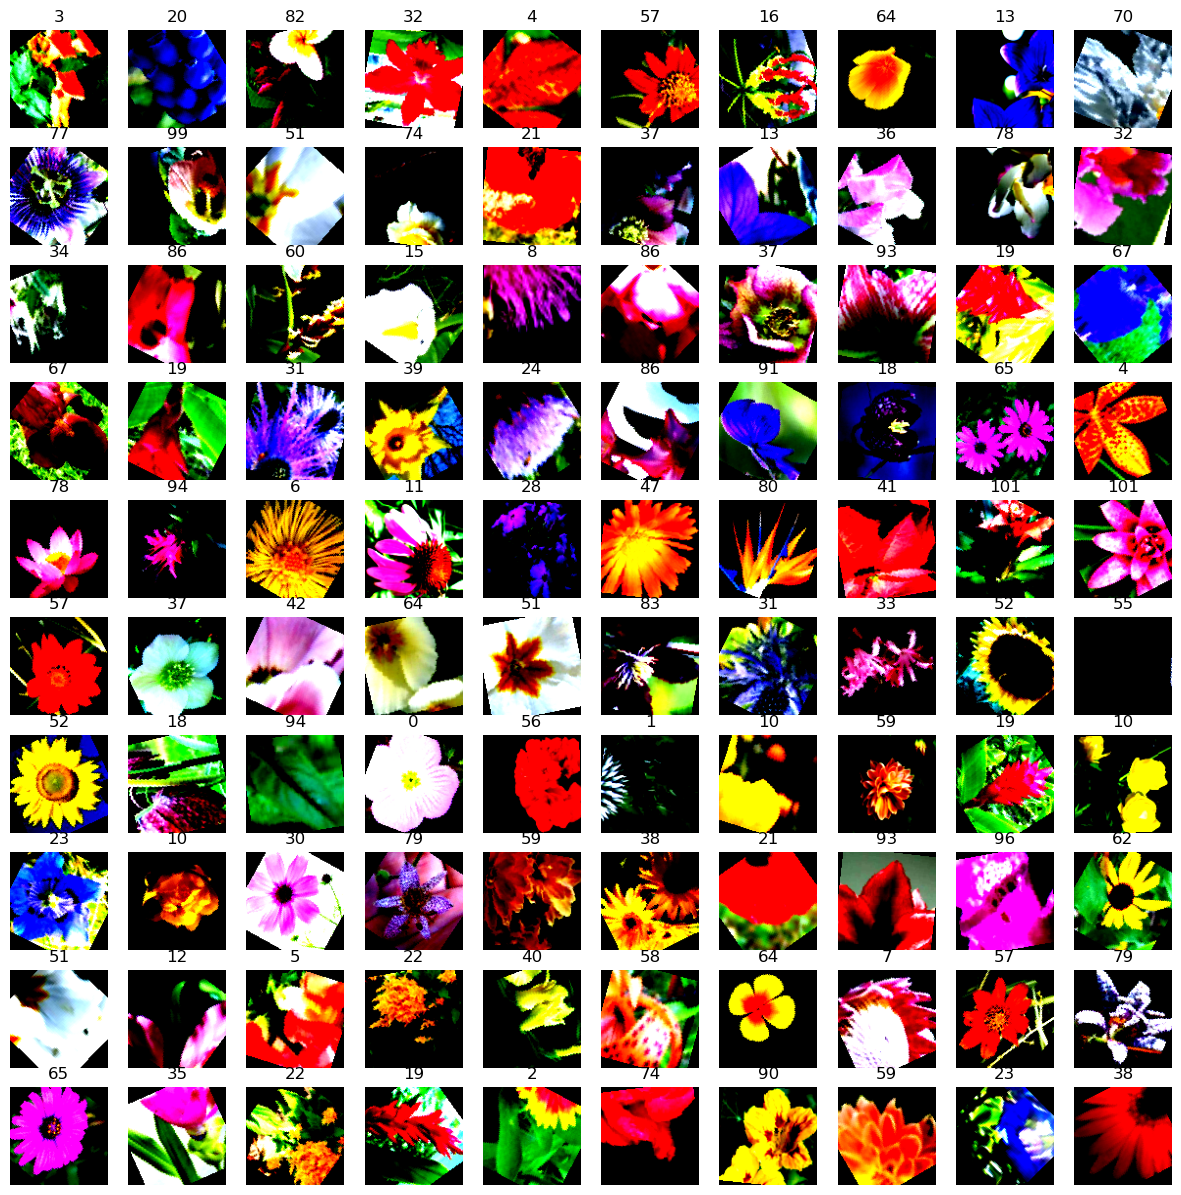

In [58]:
figure = plt.figure(figsize=(15, 15))
cols, rows = 3, 3
torch.manual_seed(12345)
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainingData), size=(1,)).item()
    img, label = trainingData[int(sample_idx)]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    processed_image = np.rollaxis(img.squeeze().numpy(), 0, 3)
    # processed_image = img.squeeze()
    # print(processed_image.shape)
    plt.imshow(processed_image)
plt.show()

In [59]:
# CNN Network
class ConvNet(nn.Module):
    def __init__(self, img_size, num_classes=102):
        super(ConvNet, self).__init__()

        # Input Shape = (3, img_size, img_size)

        # Output size
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1
        )
        self.bn1 = nn.BatchNorm2d(num_features=12)
        self.relu1 = nn.ReLU()

        # Reduce Image by a size factor of 2
        self.pool = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(
            in_channels=12, out_channels=20, kernel_size=3, stride=1, padding=1
        )
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(
            in_channels=20, out_channels=32, kernel_size=3, stride=1, padding=1
        )
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.relu3 = nn.ReLU()

        self.fc = nn.Linear(32 * 75 * 75, out_features=num_classes)